# Import and loading

In [1]:
import sys
sys.path.insert(1, '../') 
from utils.loader import Loader
from utils.data_processor import Data_processor
from utils.evaluator import Evaluator
from utils.master_generator import MasterGenerator


import cuml
import pandas as pd
from sklearn import tree
import os
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.decomposition import PCA,TruncatedSVD, IncrementalPCA, TruncatedSVD
from sklearn.linear_model import LinearRegression
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_absolute_error, make_scorer
from sklearn.tree import DecisionTreeRegressor
from sklearn.feature_selection import chi2
from sklearn.naive_bayes import GaussianNB, MultinomialNB, ComplementNB, BernoulliNB, CategoricalNB
from sklearn.svm import SVR, SVC
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
import prince
import optuna
import numpy as np

/home/liingfeng/Desktop/cuml/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2024-12-22 23:21:23.060655: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1734906083.072112   28530 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1734906083.075616   28530 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-22 23:21:23.088481: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical

In [2]:
data = Loader.load_by_fueltype("Combustion")
data = data.sample(n=60000, random_state=42)

/home/liingfeng/Desktop/repos/Cars_Price_Prediction/Trees/../utils/loader.py:153: DtypeWarning: Columns (120) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path,
/home/liingfeng/Desktop/repos/Cars_Price_Prediction/Trees/../utils/loader.py:153: DtypeWarning: Columns (120) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path,
/home/liingfeng/Desktop/repos/Cars_Price_Prediction/Trees/../utils/loader.py:165: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on t

# Functions

In [3]:
def drop_columns_full_nan(data: pd.DataFrame) -> pd.DataFrame:
    #Remove the column that only contain NAs
    cols_to_drop = data.columns[data.isna().all()]
    data = data.drop(cols_to_drop, axis=1)
    return data

def get_combustion_numerical_columns (data: pd.DataFrame) -> pd.DataFrame:
    numerical_columns = data.select_dtypes(include=['number'])

    #if all the values of the numerical columns is 0, we rem['Combustion']ove the column
    cols_to_drop = numerical_columns.columns[(numerical_columns == 0).all()]
    numerical_columns = numerical_columns.drop(cols_to_drop, axis=1)
    return numerical_columns

def fill_combustion_numerical_columns(numerical_columns: pd.DataFrame) -> pd.DataFrame:
    cols_mode = ['displacement_liters','doors','seatingCapacity','number_of_cylinders','cubicCapacity',"dimensions.length","dimensions.height","Llantas_Diametro_cm","number_of_cylinders","bore_diameter","stroke_length"]
    #fill the elemental columns that has a minor amount of missing data with the mode
    for col in cols_mode:
        numerical_columns = Data_processor.fill_na_with_mode(numerical_columns, col)

    #fill the missing data witch regression, the parameters were based on the relation matrix 
    numerical_columns = Data_processor.impute_with_linear_regression(data=numerical_columns, x_columns=["dimensions.length", "dimensions.height"], y_column="dimensions.width")
    numerical_columns = Data_processor.impute_with_linear_regression(data=numerical_columns, x_columns=["dimensions.length", "dimensions.height", "dimensions.width"], y_column="trunkCapacityInLiters")
    numerical_columns = Data_processor.impute_with_linear_regression(data=numerical_columns, x_columns=["power_cv", "power_kw"], y_column="maxSpeed")
    numerical_columns = Data_processor.impute_with_linear_regression(data=numerical_columns, x_columns=["power_cv", "power_kw", "maxSpeed"], y_column="acceleration")
    numerical_columns = Data_processor.impute_with_linear_regression(data=numerical_columns, x_columns=["power_cv", "power_kw", "maxSpeed"], y_column="acceleration")
    numerical_columns = Data_processor.impute_with_linear_regression(data=numerical_columns, x_columns=["Llantas_Diametro_cm", "power_kw"], y_column="max_torque_nm")
    numerical_columns = Data_processor.impute_with_linear_regression(data=numerical_columns, x_columns=["Llantas_Diametro_cm", "power_kw"], y_column="rpm_max_torque")
    numerical_columns = Data_processor.impute_with_linear_regression(data=numerical_columns, x_columns=["Llantas_Diametro_cm", "power_kw"], y_column="rpm_max_power")
    numerical_columns.dropna(axis=1, inplace=True)
    return numerical_columns

def get_combustion_categorical_columns(df: pd.DataFrame) -> pd.DataFrame:
    # Select and print only the categorical columns
    ret = df.select_dtypes(include=['category'])
    
    # Temporarily convert the column to strings to perform the replacement
    ret['traction'] = ret['traction'].astype(str).replace({"trasera": "trasero", "delantera": "delantero"})
    # Convert back to a categorical type
    ret['traction'] = ret['traction'].astype('category')

    
    # Remove redundant columns if this function is defined
    ret = Data_processor.remove_redundand_columns(ret)
    return ret


def fill_combustion_categorical_columns(df: pd.DataFrame) -> pd.DataFrame:
    mode_cols = ['brakes','version','jato_classification']
    for col in mode_cols:
        df = Data_processor.fill_na_with_mode(df, col)
    df = Data_processor.impute_categorical_mode(df=df, X=["brand", "model", "traction","brakes"], Y="front_suspension")
    df = Data_processor.impute_categorical_mode(df=df, X=["brand", "model", "traction","brakes"], Y="rear_suspension")
    df = Data_processor.impute_categorical_mode(df=df, X=["brand", "model"] , Y="environmentalLabel")
    return df

def category_convert(df: pd.DataFrame) -> pd.DataFrame:
    cols_to_convert = df.select_dtypes(include=['object']).columns
    for col in cols_to_convert:
        df[col] = df[col].astype('category')
    return df


# Column filters

In [4]:
# Quit all electric columns from data['Combustion']
for column in data.columns:
    if column.startswith('electric'):
        data = data.drop(columns=column)

In [5]:
# convert object columns to category
data = category_convert(data)

categorical_columns = get_combustion_categorical_columns(data)

categorical_columns = fill_combustion_categorical_columns(categorical_columns)

# Check amount of missing values
missing_values = categorical_columns.isnull().sum()
missing_values = missing_values[missing_values > 0]

print(missing_values)
categorical_columns.head()
categorical_columns.columns
#categorical_columns['traction']

Number of missing values in 'front_suspension' before filling with 'unknown': 17
Number of missing values in 'rear_suspension' before filling with 'unknown': 36
Number of missing values in 'environmentalLabel' before filling with 'unknown': 5
Series([], dtype: int64)


Index(['color', 'brand', 'model', 'version', 'fuelType', 'bodyTypeId',
       'transmissionTypeId', 'province', 'environmentalLabel',
       'jato_classification', 'traction', 'brakes', 'front_suspension',
       'rear_suspension', 'Acabado Exterior_Alerón',
       'Acabado Exterior_Cristales', 'Acabado Exterior_Faldones',
       'Acabado Exterior_Pintura', 'Acabado Exterior_Rueda', 'AC_Zones',
       'AC_Type', 'Metodo_Apertura', 'Tipo_Faro', 'interior_clock',
       'arm_suppport_front', 'arm_suppport_back', 'price_categ'],
      dtype='object')

In [6]:
# Drop all na columns 
data = drop_columns_full_nan(data)

numerical_columns = get_combustion_numerical_columns(data)


# fill the missing data in numerical columns
numerical_columns = fill_combustion_numerical_columns(numerical_columns)

# Check amount of missing values
missing_values_num = numerical_columns.isnull().sum()
missing_values_num = missing_values_num[missing_values_num > 0]

data[numerical_columns.columns] = numerical_columns

#correlation_matrix = numerical_columns.corr()
#correlation_matrix = correlation_matrix.sort_values(by='price', ascending=False)
print(missing_values_num)

Regression mape ['dimensions.length', 'dimensions.height'] -> dimensions.width: 1.6027653890702778%
Regression mape ['dimensions.length', 'dimensions.height', 'dimensions.width'] -> trunkCapacityInLiters: 17.87938915450402%
Regression mape ['power_cv', 'power_kw'] -> maxSpeed: 6.42047688270483%
Regression mape ['power_cv', 'power_kw', 'maxSpeed'] -> acceleration: 7.8408908843335565%
Regression mape ['power_cv', 'power_kw', 'maxSpeed'] -> acceleration: 6.760677483501907%
Regression mape ['Llantas_Diametro_cm', 'power_kw'] -> max_torque_nm: 2.369309770553849e+16%
Regression mape ['Llantas_Diametro_cm', 'power_kw'] -> rpm_max_torque: 64.21837008629997%
Regression mape ['Llantas_Diametro_cm', 'power_kw'] -> rpm_max_power: 20.091682222640802%
Series([], dtype: int64)


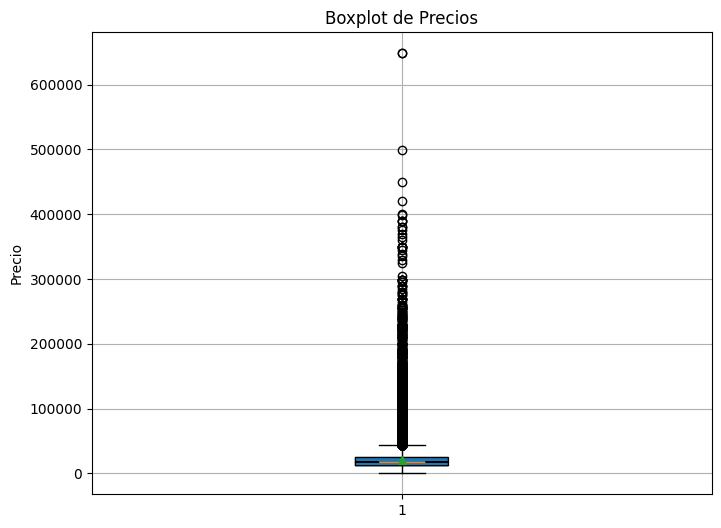

In [7]:
precios_combustion = data["price"]
plt.figure(figsize=(8, 6))
plt.boxplot(precios_combustion, notch=True, vert=True, patch_artist=True, showmeans=True)
plt.title('Boxplot de Precios')
plt.ylabel('Precio')
plt.grid(True)
plt.show()

Even though there seems to be many outliers in the data, after a manual inspection, it was found that the data is correct and the outliers are valid data points. (Most of them are from luxury brands such as Lamborghini, Ferrari, etc.)

In [8]:
Q1 = data['price'].quantile(0.25)
Q2 = data['price'].quantile(0.5)
Q3 = data['price'].quantile(0.75)
IQR = Q3 - Q1

upper_whisker = (Q3 + 1.5 * IQR)
print(upper_whisker)

data[data["price"]>upper_whisker][["price", "brand"]].sort_values(by='price', ascending=False)[:10]

43951.875


,price,brand
idx,,
18873,648500,FERRARI
16685,648500,FERRARI
16086,499900,FERRARI
66148,449999,PORSCHE
65994,419999,PORSCHE
37932,399900,FERRARI
126850,398990,PORSCHE
65985,389900,PORSCHE
80418,389900,PORSCHE


# PCA

In [9]:
scaler = StandardScaler()
df_scaled  = scaler.fit_transform(numerical_columns)

pca = PCA(n_components=2)
principal_components = pca.fit_transform(df_scaled)
df_pca = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2'])

In [10]:
principal_components

array([[ 3.64104349, -7.44882403],
       [-1.06506284, -0.2019002 ],
       [-1.07927685, -0.18789188],
       ...,
       [-3.17092577, -1.93417464],
       [-0.44656463, -1.05582589],
       [ 1.17505692, -0.20371141]])

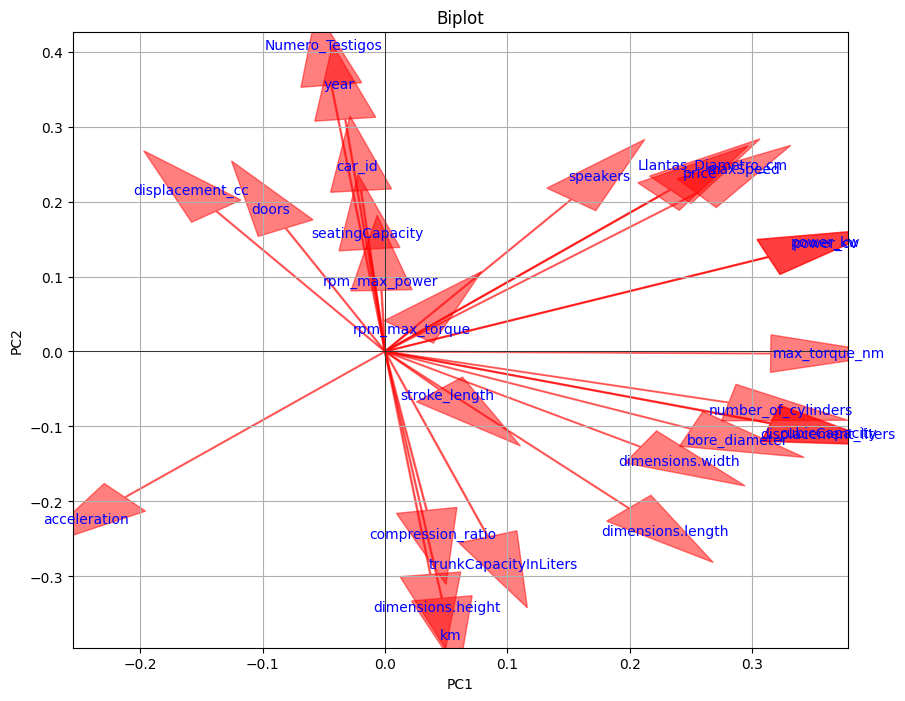

In [11]:
def biplot(score, coeff, labels=None):
    plt.figure(figsize=(10, 8))
    origin = [0, 0]  # Origen de las flechas

    # Dibujar las flechas
    for i in range(len(coeff)):
        plt.arrow(origin[0], origin[1], coeff[i,0], coeff[i,1], color='r', alpha=0.5, head_width=0.05, head_length=0.1)
        if labels is not None:
            plt.text(coeff[i,0]*1.15, coeff[i,1]*1.15, labels[i], color='blue', ha='center', va='center')

    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.title("Biplot")
    plt.grid(True)
    plt.axhline(0, color='black',linewidth=0.5)
    plt.axvline(0, color='black',linewidth=0.5)
    plt.xlim(min(coeff[:,0])*1.2, max(coeff[:,0])*1.2)
    plt.ylim(min(coeff[:,1])*1.2, max(coeff[:,1])*1.2)
    plt.show()

# Llamada a la función biplot
biplot(principal_components, np.transpose(pca.components_[0:2, :]), labels=numerical_columns.columns)

# Test CART regression trees with only numerical variables

In [12]:
X = numerical_columns.drop(columns="price")
y = numerical_columns["price"]

# Since too many features + rows are present, we will use PCA to reduce the dimensionality
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Apply PCA
pca = PCA(n_components=0.95)  # Keep 95% of variance
X_pca = pca.fit_transform(X_scaled)

# Check PCA-transformed data
print(f"Original shape: {X.shape}, Transformed shape: {X_pca.shape}")


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

tree_model = DecisionTreeRegressor(random_state=42)
tree_model.fit(X_train, y_train)

Original shape: (60000, 26), Transformed shape: (60000, 17)


DecisionTreeRegressor(random_state=42)

MAE: 2640.311595670996 
 MSE: 40606542.51780078 
 RMSE: 6372.326303462557 
 R2: 0.8978889790613936 
 MAPE: 14.267049923170068
Mean: 2640.311595670996
Variance: 33635297.19556606
Standard Deviation: 5799.594571654648


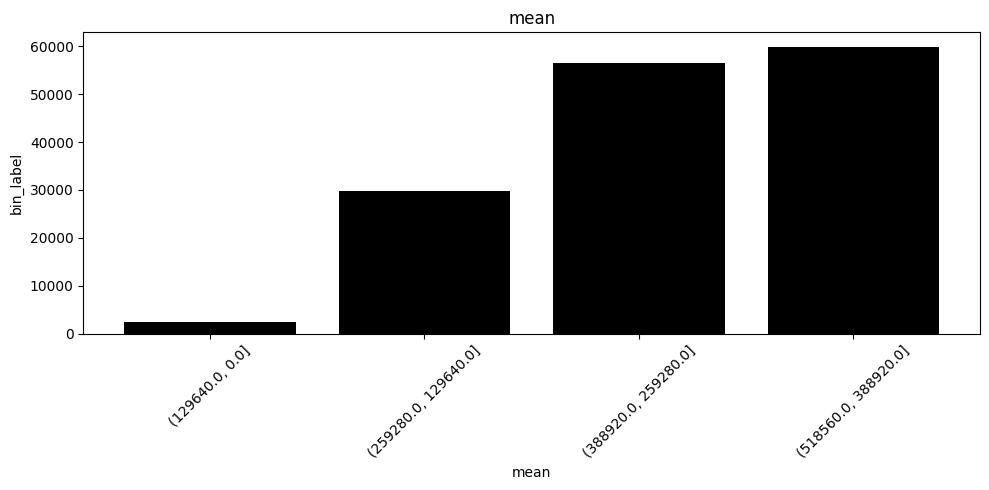

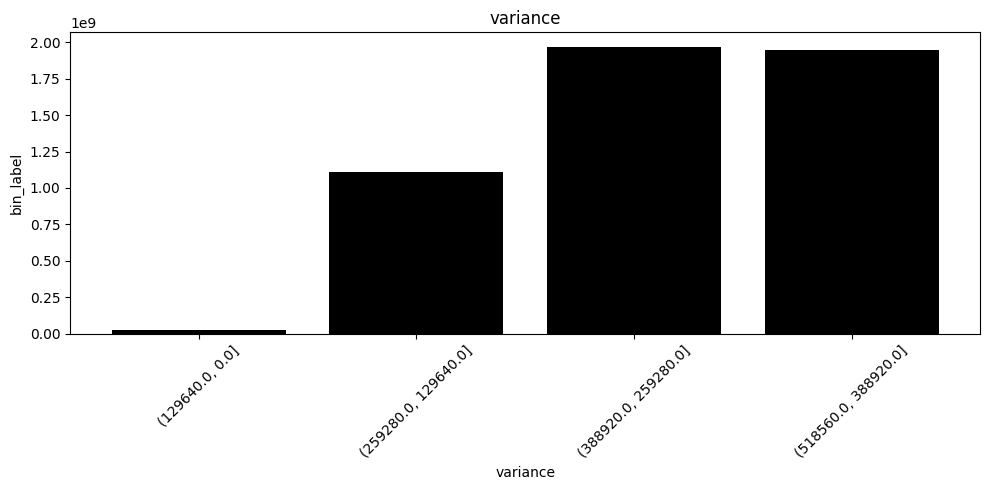

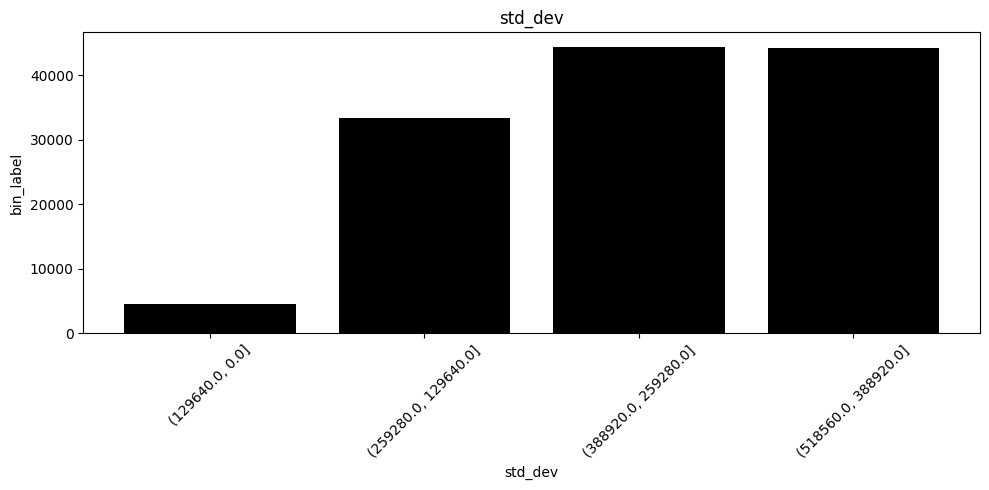

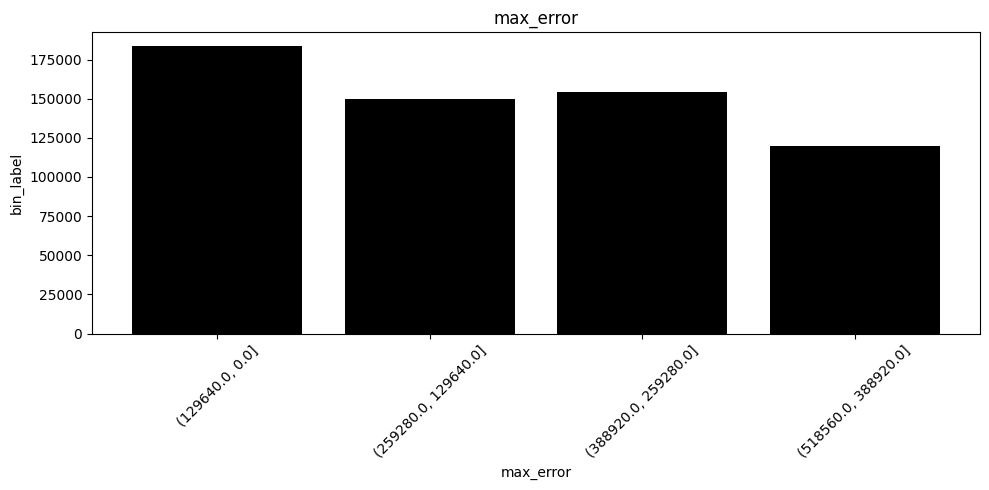

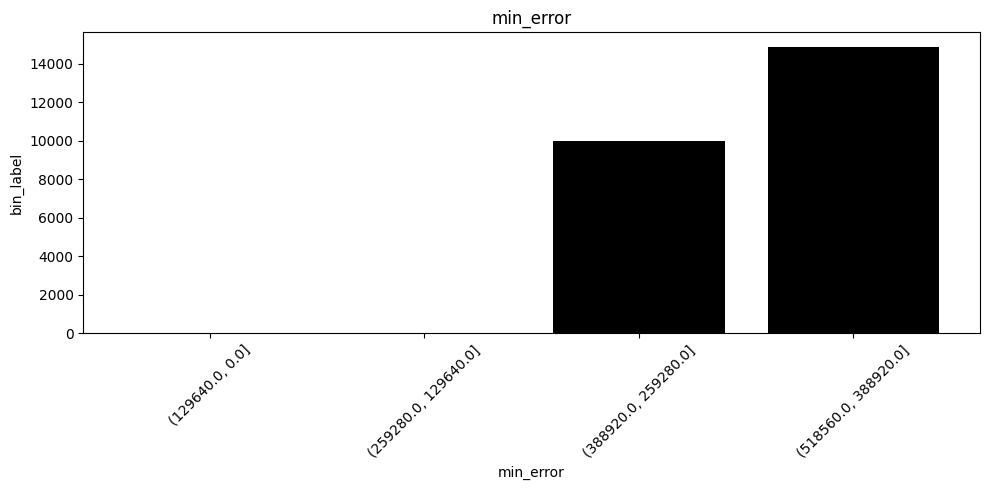

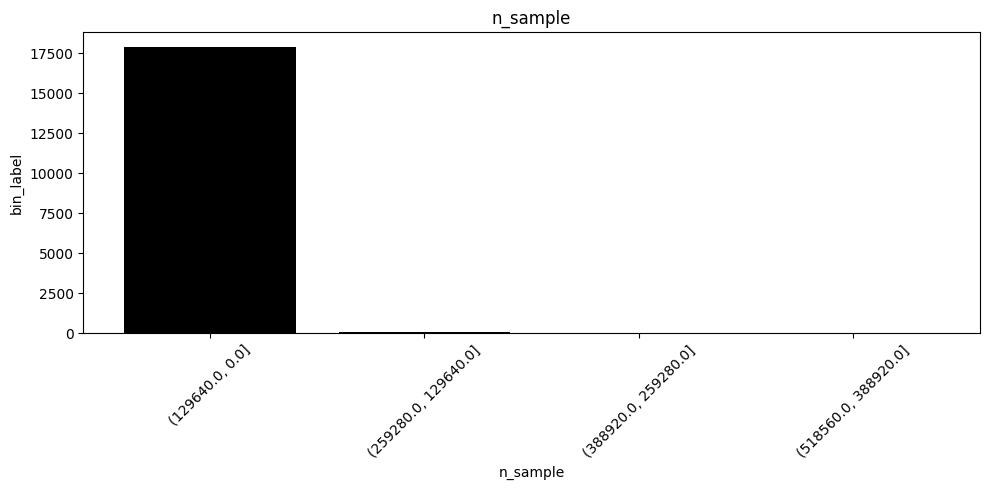

,bin_label,mean,variance,std_dev,max_error,min_error,n_sample
0,"(129640.0, 0.0]",2469.238559,2.131586e+07,4616.909999,183400.0,0.0,17898
1,"(259280.0, 129640.0]",29695.157303,1.109067e+09,33302.651009,150000.0,0.0,89
2,"(388920.0, 259280.0]",56499.888889,1.970794e+09,44393.624418,154500.0,10000.0,9
3,"(518560.0, 388920.0]",59936.333333,1.949412e+09,44152.145817,119910.0,14900.0,3


In [13]:
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# Realizar predicciones sobre el conjunto de prueba
y_pred = tree_model.predict(X_test)

Evaluator.eval_regression(y_pred, y_test)

# CA

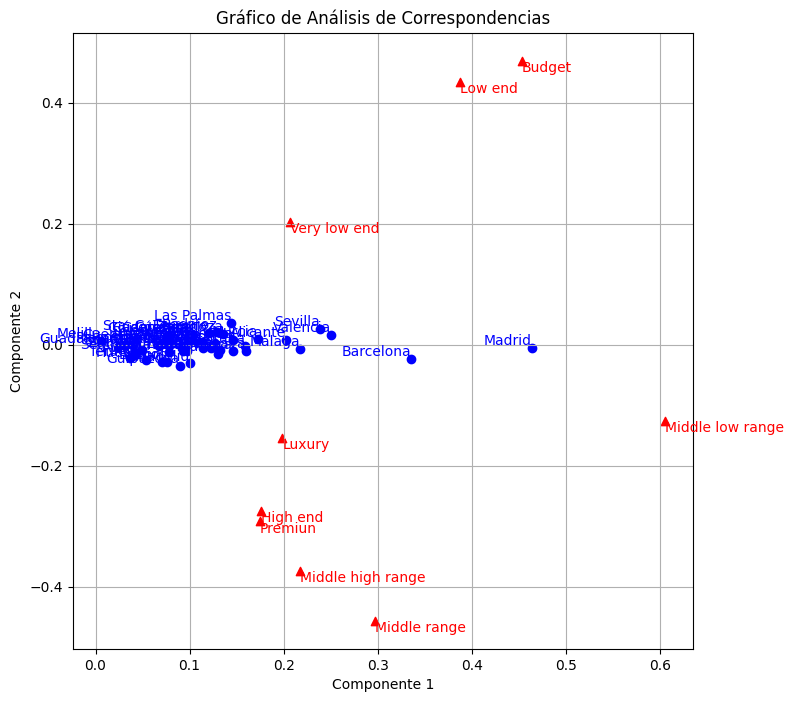

In [14]:
Data_processor.CA(categorical_columns=categorical_columns, col_x="province", col_y="price_categ")

In [15]:
categorical_columns["price_categ"].value_counts()

price_categ
Middle low range     21948
Budget               12306
Low end               9004
Middle range          5295
Middle high range     2846
Very low end          2562
Luxury                2367
High end              1849
Premiun               1823
Name: count, dtype: int64

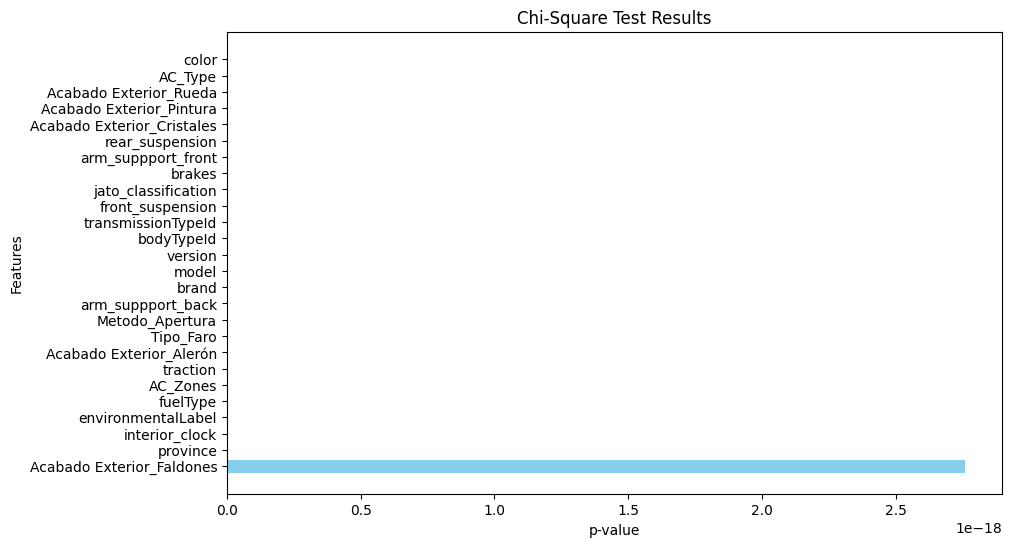

Index(['color', 'AC_Type', 'Acabado Exterior_Rueda',
       'Acabado Exterior_Pintura', 'Acabado Exterior_Cristales',
       'rear_suspension', 'arm_suppport_front', 'brakes',
       'jato_classification', 'front_suspension', 'transmissionTypeId',
       'bodyTypeId', 'version', 'model', 'brand', 'arm_suppport_back',
       'price_categ'],
      dtype='object')

In [16]:
categorical_columns = Data_processor.chi_square_filter(categorical_columns, "price_categ", p_value_filter=0)
categorical_columns.columns

# Categorical

## Test CART tree classifier with only categorical values

In [17]:
features_df = pd.get_dummies(categorical_columns.drop('price_categ', axis=1))

# Your target variable
target = categorical_columns['price_categ'].apply(Loader.encode_price_categ)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features_df, target, test_size=0.3, random_state=42)

# Initialize and train the Decision Tree Classifier
cart_model = DecisionTreeClassifier(random_state=42)
cart_model.fit(X_train, y_train)

# Predicting the test set results
y_pred = cart_model.predict(X_test)

In [18]:
y_test

idx
95236     3
161570    3
113154    3
127587    0
122586    1
         ..
88332     0
79089     2
161148    2
58704     4
88816     3
Name: price_categ, Length: 18000, dtype: category
Categories (9, int64): [2, 6, 1, 8, ..., 3, 4, 7, 0]

In [19]:
result = pd.DataFrame({"Real_Categorie": y_test, "Prediction": y_pred})
result["diff"] = np.abs(result["Real_Categorie"].astype(int) - result["Prediction"])
result["Real_Categorie"] = result["Real_Categorie"].apply(Loader.decode_price_categ)
result["Prediction"] = result["Prediction"].apply(Loader.decode_price_categ)
result

,Real_Categorie,Prediction,diff
idx,,,
95236,Budget,Budget,0
161570,Budget,Budget,0
113154,Budget,Budget,0
127587,Very low end,Very low end,0
122586,Low end,Low end,0
...,...,...,...
88332,Very low end,Low end,1
79089,Middle low range,Middle low range,0
161148,Middle low range,Middle low range,0


In [20]:
# Calcular la precisión
Evaluator.eval_classification(y_pred=result["Prediction"].to_numpy(), y_true=result["Real_Categorie"].to_numpy(), binary_classification=False)

Accuracy: 0.6671111111111111 
 Precision: 0.662817491306865 
 Recall: 0.6671111111111111 
 F1 Score: 0.664637759863849
Confusion Matrix:
 [[5229   24   66    3   72  738  383   11    6]
 [  44  203    2   16  131    1   67   83    0]
 [  69    1 1852    3    0  570    4    5  227]
 [  16   15    1  545   11    1   12   89    0]
 [ 111  113    4    8  303   15  216   36    0]
 [ 775    1  604    3    6 2312   12    1   20]
 [ 557   43    7    7  163   13  811   20    1]
 [  36  112    3   75   46    1   34  251    1]
 [   7    0  242    0    1   25    1    1  502]]


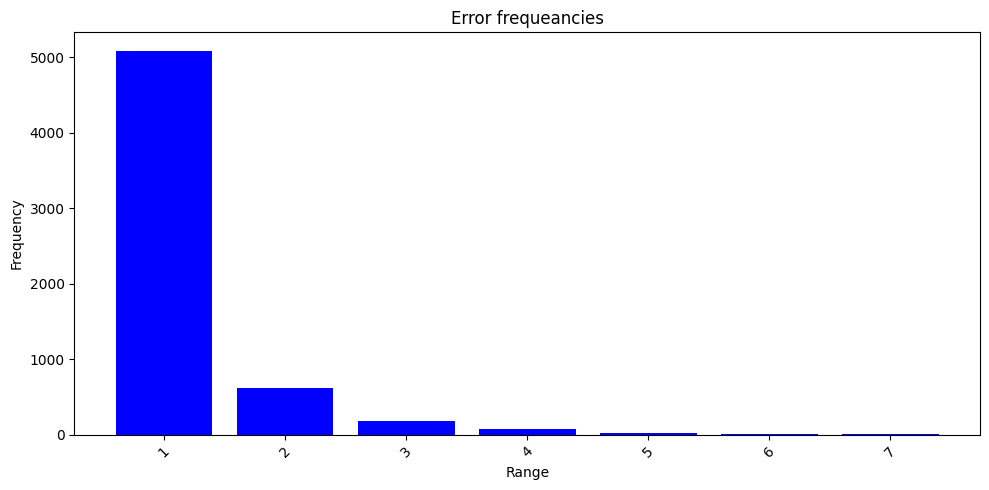

{1: 5078, 2: 611, 3: 186, 4: 74, 5: 25, 6: 12, 7: 6}
Error mean: 1.2338117489986649
Error rate: 33.28888888888889 %
Overall mean: 0.4107222222222222


In [21]:
Evaluator.eval_ordinal_classification (result["diff"])

Even though the accuracy is only about 70% the errors are not a concern as many of the errors are of degree 1 (the guess was not far off)

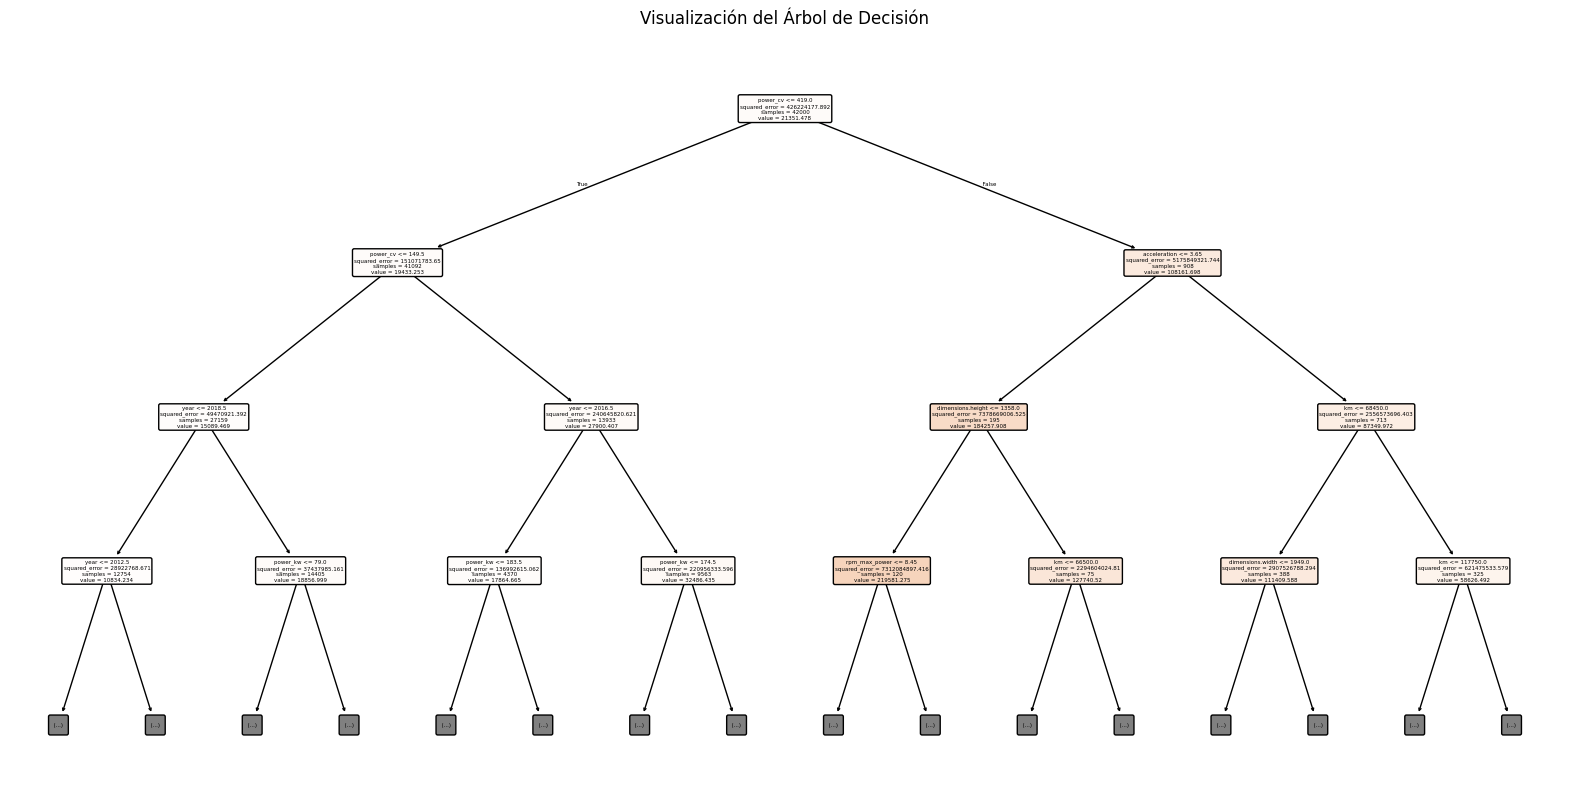

In [22]:
plt.figure(figsize=(20,10))

# Dibujar el árbol de decisión
plot_tree(tree_model, 
          filled=True, 
          rounded=True, 
          class_names=X_train.columns, 
          feature_names=X.columns, 
          max_depth=3)  # Puedes ajustar la profundidad para una mejor visualización o quitar este parámetro para mostrar todo el árbol
plt.title('Visualización del Árbol de Decisión')
plt.show()

In [23]:
# Merge numerical and categorical columns
combustion_cars = pd.merge(numerical_columns, categorical_columns, left_index=True, right_index=True, how="inner")
numerical_column_names = list(numerical_columns.columns)
categorical_column_names = list(categorical_columns.columns)

# Separate target variables
target = combustion_cars[["price", "price_categ"]]
target["price_categ"] = target["price_categ"].apply(Loader.encode_price_categ)
combustion_cars.drop(columns=["price", "price_categ"], inplace=True)

# Update feature lists by removing targets
numerical_column_names.remove("price")
categorical_column_names.remove("price_categ")

# Initialize dictionary to store encoders/scalers
encoders_and_scalers = {}

# Scale and apply PCA to numerical columns
numerical_data = combustion_cars[numerical_column_names]
scaler = StandardScaler()
numerical_data_scaled = scaler.fit_transform(numerical_data)

# Apply IncrementalPCA to numerical data
incremental_pca_numerical = PCA(n_components=0.95)
numerical_data_pca = incremental_pca_numerical.fit_transform(numerical_data_scaled)

# Store the scaler and PCA for numerical columns
encoders_and_scalers["numerical_scaler"] = scaler
encoders_and_scalers["numerical_pca"] = incremental_pca_numerical

# Encode categorical columns (sparse matrix)
encoder = OneHotEncoder(handle_unknown="ignore", sparse_output=True)
categorical_data_encoded = encoder.fit_transform(combustion_cars[categorical_column_names])

# Instead of PCA on categorical data, use TruncatedSVD for sparse matrix
svd_categorical = TruncatedSVD(n_components=30)
categorical_data_svd = svd_categorical.fit_transform(categorical_data_encoded)

# Store the encoder and SVD for categorical columns
encoders_and_scalers["categorical_encoder"] = encoder
encoders_and_scalers["categorical_svd"] = svd_categorical

# Combine the PCA-transformed numerical and SVD-transformed categorical data
combustion_cars_encoded = pd.DataFrame(
    data=np.hstack([numerical_data_pca, categorical_data_svd]),
    index=combustion_cars.index
)

print("Shape after dimensionality reduction:")
print(combustion_cars_encoded.shape)

/tmp/ipykernel_28530/2385894330.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  target["price_categ"] = target["price_categ"].apply(Loader.encode_price_categ)


Shape after dimensionality reduction:
(60000, 47)


## Classification

In [24]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(combustion_cars_encoded, target['price_categ'], test_size=0.3, random_state=42)

In [25]:
target['price_categ']

idx
9745      4
39559     3
20639     3
46724     0
150173    6
         ..
82290     3
106449    0
165051    0
65330     3
148673    3
Name: price_categ, Length: 60000, dtype: category
Categories (9, int64): [2, 6, 1, 8, ..., 3, 4, 7, 0]

In [26]:
import cuml.ensemble


def eval_classification(y_test, y_pred):
    result = pd.DataFrame({"Real": y_test, "Prediction": y_pred})
    result["diff"] = result["Real"].apply(Loader.encode_price_categ).to_numpy() - result["Prediction"].apply(Loader.encode_price_categ).to_numpy()
    Evaluator.eval_ordinal_classification(diff=result["diff"])

def classify(X_train, X_test, y_train, y_test , classifier, classifier_name = None) -> None:
    classifier = classifier
    classifier.fit(X_train, y_train)

    # Predicting the test set results
    y_pred = classifier.predict(X_test)
    eval_classification(y_test, y_pred)

    if classifier_name != None:
        return Evaluator.eval_classification(y_pred = y_pred, y_true=y_test, binary_classification=False, classifier_name=classifier_name)
    return Evaluator.eval_classification(y_pred = y_pred, y_true=y_test, binary_classification=False)


def objective(trial, classifier_name):
    # Obtén los datos
    x, y = combustion_cars_encoded, target['price_categ']

    # Divide los datos en entrenamiento y prueba
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)

    # Define el clasificador basado en el nombre
    if classifier_name == "SVC":
        C = trial.suggest_float("svc_c", 1e-10, 1e10, log=True)
        classifier_obj = SVC(C=C, gamma="auto")
    elif classifier_name == "RandomForest":
        max_depth = trial.suggest_int("max_depth", 2, 32, log=True)
        classifier_obj = cuml.ensemble.RandomForestClassifier(max_depth=max_depth, n_estimators=10)
    elif classifier_name == "CART":
        max_depth = trial.suggest_int("max_depth", 2, 32, log=True)
        classifier_obj = cuml.ensemble.DecisionTreeClassifier(max_depth=max_depth)
    else:
        raise ValueError(f"Unknown classifier_name: {classifier_name}")

    # Entrena el modelo en los datos de entrenamiento
    classifier_obj.fit(x_train, y_train)

    # Predice los datos de prueba
    y_pred = classifier_obj.predict(x_test)

    # Calcula la precisión
    accuracy = accuracy_score(y_test, y_pred)
    return accuracy


## Cart

In [27]:

classifier_name = "RandomForest"

study = optuna.create_study(direction="maximize")
study.optimize(lambda trial: objective(trial,classifier_name), n_trials=100)

max_depth = study.best_params.get("max_depth")

classify(X_train, X_test, y_train, y_test, DecisionTreeClassifier(random_state=42, max_depth=max_depth), classifier_name)

[I 2024-12-22 23:21:52,197] A new study created in memory with name: no-name-60353109-fd4f-4636-b950-e9c2000057c1
/home/liingfeng/Desktop/cuml/lib/python3.12/site-packages/cuml/internals/api_decorators.py:188: UserWarning: To use pickling first train using float32 data to fit the estimator
  ret = func(*args, **kwargs)
[I 2024-12-22 23:21:52,505] Trial 0 finished with value: 0.5851111111111111 and parameters: {'max_depth': 7}. Best is trial 0 with value: 0.5851111111111111.
/home/liingfeng/Desktop/cuml/lib/python3.12/site-packages/cuml/internals/api_decorators.py:188: UserWarning: To use pickling first train using float32 data to fit the estimator
  ret = func(*args, **kwargs)
[I 2024-12-22 23:21:52,585] Trial 1 finished with value: 0.5851111111111111 and parameters: {'max_depth': 7}. Best is trial 0 with value: 0.5851111111111111.
/home/liingfeng/Desktop/cuml/lib/python3.12/site-packages/cuml/internals/api_decorators.py:188: UserWarning: To use pickling first train using float32 data 

MemoryError: std::bad_alloc: out_of_memory: CUDA error at: /__w/cuml/cuml/python/cuml/build/cp312-cp312-linux_x86_64/_deps/rmm-src/include/rmm/mr/device/cuda_memory_resource.hpp:62: cudaErrorMemoryAllocation out of memory

### Random Forest

In [ ]:
classify(X_train, X_test, y_train, y_test, RandomForestClassifier(random_state=42), classifier_name="RandomForestClassifier")

### SVM

In [ ]:
#classify(X_train, X_test, y_train, y_test, SVC(random_state=42), classifier_name="SVC")

### Naive Bayes

In [ ]:
classify(X_train, X_test, y_train, y_test, GaussianNB(), classifier_name="Naive bayes") # GaussianNB seems to give the best results

### ANN

In [ ]:
encoder = OneHotEncoder(sparse_output=False)
y_encoded = encoder.fit_transform(target[['price_categ']])

# Step 2: Split the data
X_train, X_test, y_train, y_test = train_test_split(
    combustion_cars_encoded, y_encoded, test_size=0.3, random_state=42
)

# Step 3: Normalize the data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Step 4: Define the ANN model
model = Sequential()
model.add(Dense(128, input_dim=X_train.shape[1], activation='relu'))
model.add(Dense(64, activation='tanh'))
model.add(Dense(32, activation='tanh'))
model.add(Dense(y_train.shape[1], activation='softmax'))  # Softmax for multi-class classification

# Step 5: Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Step 6: Train the model
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=100, batch_size=128)

In [ ]:
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_test_classes = np.argmax(y_test, axis=1)

In [ ]:
Evaluator.eval_classfication(y_pred=y_pred_classes, y_true=y_test_classes, binary_classification=False, classifier_name="ANN")

## Regression

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(combustion_cars_encoded, target['price'], test_size=0.3, random_state=42)

In [ ]:
def regression(X_train, X_test, y_train, y_test , regressor, regressor_name = None) -> None:
    regressor.fit(X_train, y_train)

    # Predicting the test set results
    y_pred = regressor.predict(X_test)
    if regressor_name != None:
        Evaluator.eval_regression(y_pred = y_pred, y_true=y_test, plot=False, n_features=X_train.shape[1], regressor_name=regressor_name)
    else :Evaluator.eval_regression(y_pred = y_pred, y_true=y_test, plot=False)
    mape_scorer = make_scorer(mean_absolute_percentage_error, greater_is_better=False)
    cv_scores = -cross_val_score(regressor, X_test, y_test, cv=5, scoring=mape_scorer)
    Evaluator.plot_bar_chart_key_value(keys= [f"Fold {i+1}" for i in range(len(cv_scores))], values=cv_scores, title=f"Accuracy 5 folder Cross-validation", xlabel="fold", ylabel="MAPE")

### Cart

In [ ]:
regression(X_train, X_test, y_train, y_test , DecisionTreeRegressor(random_state=42), regressor_name="CART")

### Random Forest

In [ ]:
regression(X_train, X_test, y_train, y_test , RandomForestRegressor(random_state=42), regressor_name="RandomForest")

### SVM Regression

In [ ]:
regression(X_train, X_test, y_train, y_test , SVR(kernel='rbf'), regressor_name="SVR")

### Multivariable Regression

In [ ]:
linear_regressor = LinearRegression()
linear_regressor.fit(X_train, y_train)

# Predicting the test set results
y_pred = linear_regressor.predict(X_test)

# Optionally, display the coefficients of the model
print("Coefficients:", linear_regressor.coef_)
print("Intercept:", linear_regressor.intercept_)

In [ ]:
result = pd.DataFrame({"Real": y_test, "Prediction": y_pred})
result["diff"] = result["Real"].to_numpy() - result["Prediction"].to_numpy()

## ANN

### Regression

In [ ]:
# Define the model
model = Sequential()

model.add(Dense(128, input_dim=X_train.shape[1], activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(16, activation='linear'))
model.add(Dense(1))

In [ ]:
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])

In [ ]:
# Train the model
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=100, batch_size=128)

In [ ]:
loss, mae = model.evaluate(X_test, y_test, verbose=2)
print(f"Mean Absolute Error on test set: {mae:.2f}")

In [ ]:
# Plot the loss curve
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Model Loss Curve')
plt.show()

In [ ]:
y_pred = model.predict(X_test).flatten()

In [ ]:
Evaluator.eval_regression(y_pred=y_pred, y_true=y_test, plot=False, n_features=X_train.shape[1], regressor_name="ANN")

In [ ]:
Evaluator.save("combustion")

In [28]:
master = MasterGenerator(X=combustion_cars_encoded, y_categ=target["price_categ"], y_numeric=target["price"], n_tries=1, CUML=True, name="HP_combustion")

In [29]:
master._clustering_generate()

[I 2024-12-22 23:22:21,300] A new study created in memory with name: no-name-7203b933-f494-46eb-b43f-09639dc94f1c


Optimizing method: kmeans


[I 2024-12-22 23:22:47,618] Trial 0 finished with value: 0.14781741324406983 and parameters: {'n_clusters': 4, 'init': 'random', 'n_init': 49, 'max_iter': 445}. Best is trial 0 with value: 0.14781741324406983.
[I 2024-12-22 23:23:13,987] A new study created in memory with name: no-name-f82b9b0f-f2e4-4f9b-92e2-03b7fae2d8d5


Optimizing method: agglomerative


[I 2024-12-22 23:25:38,954] Trial 0 finished with value: 0.13903848401418645 and parameters: {'n_clusters': 6, 'linkage': 'ward'}. Best is trial 0 with value: 0.13903848401418645.
[I 2024-12-22 23:28:03,131] A new study created in memory with name: no-name-3419df23-e5cf-4c46-a4f4-5784e597f028


Optimizing method: dbscan


[I 2024-12-22 23:28:34,277] Trial 0 finished with value: -0.39165138070701566 and parameters: {'eps': 0.8535912357056841, 'min_samples': 13, 'algorithm': 'auto'}. Best is trial 0 with value: -0.39165138070701566.
[I 2024-12-22 23:28:34,294] A new study created in memory with name: no-name-316316f7-80fd-42fc-9ced-4edc42641e28


Error with method dbscan: Invalid value for algorithm: auto
Optimizing method: birch


[I 2024-12-22 23:29:16,412] Trial 0 finished with value: 0.10836844676701171 and parameters: {'threshold': 0.8253930761604032, 'n_clusters': 9, 'branching_factor': 83}. Best is trial 0 with value: 0.10836844676701171.
[I 2024-12-22 23:30:01,276] A new study created in memory with name: no-name-64bfc0ae-228e-4e67-b68d-ac637103cd79


Optimizing method: optics


[I 2024-12-22 23:30:47,729] Trial 0 finished with value: -0.40582388288493626 and parameters: {'min_samples': 17, 'max_eps': 2.1540311255451132, 'metric': 'manhattan', 'cluster_method': 'dbscan'}. Best is trial 0 with value: -0.40582388288493626.
[I 2024-12-22 23:31:34,772] A new study created in memory with name: no-name-f0495731-1000-4833-9b88-088afdded0b0


Optimizing method: gmm


[I 2024-12-22 23:31:58,097] Trial 0 finished with value: 0.05484975276551262 and parameters: {'n_components': 12, 'covariance_type': 'diag', 'tol': 0.0005613606726975472, 'reg_covar': 1.8099653421478006e-06, 'max_iter': 188}. Best is trial 0 with value: 0.05484975276551262.
